# 고혈압 분석 모델
## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - columns 54

- 14차
  - 2021-09-13
  - 데이터 추가
    - AS1_WAIST3_A
    - 허리둘레
    - 계층있는 연속형
    - columns: 55

- 15차
  - 2021-09-26
  - 누락 되었던 식품군 F1 ~ F17 데이터 추가
  - 모델 제작에는 사용하지 않음

- 16차
  - 2021-10-01
  - JOBB 추가
  - 키 대신에 BMI 넣음
  - FA를 DP로 변경

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리

### 데이터 불러오기

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/year0_211001.csv', index_col=0, na_values=['NA'])

idx_dataset = list(dataset.index)
col_dataset = list(dataset.columns)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 72 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AS1_SEX        9704 non-null   int64  
 1   AS1_AGE        9704 non-null   int64  
 2   AS1_JOBB       9698 non-null   float64
 3   AS1_EDUA       9650 non-null   float64
 4   AS1_INCOME     9566 non-null   float64
 5   AS1_DRINK      9664 non-null   float64
 6   AS1_DRDUA      9545 non-null   float64
 7   AS1_TOTALC     5116 non-null   float64
 8   AS1_SMOKEA     9616 non-null   float64
 9   AS1_HVSMAM     9542 non-null   float64
 10  AS1_HVSMDU     9522 non-null   float64
 11  AS1_PHYSTB     9601 non-null   float64
 12  AS1_PHYSIT     9582 non-null   float64
 13  AS1_PHYACTL    9568 non-null   float64
 14  AS1_PHYACTM    9502 non-null   float64
 15  AS1_PHYACTH    9541 non-null   float64
 16  AS1_INSUR      9682 non-null   float64
 17  AS1_HEALTH     9675 non-nu

### dataset 결측값 대치

In [ ]:
# dataset에 있는 변수 분리
# 범주형, 연속형 등으로 분리하여 raw_var 형태로 저장하여 각각 관리한다.

# 종속변수, 고혈압
HYPERTENSION = dataset['HYPERTENSION']

# 범주형(binary, 0 or 1)
raw_binary = dataset.reindex(columns=['AS1_SEX', 'AS0_TIED', 'AS0_SLPAMSF', 'AS1_STRPHYSJ'])
col_b = raw_binary.columns

# 범주형(계층 없음, without hierarchy)
# raw_categoryH0 = dataset.reindex(columns=['AS1_INSUR'])
# col_H0 = raw_categoryH0.columns

# 범주형(계층 있음, with hierarchy)
raw_categoryH1 = dataset.reindex(columns=['AS1_EDUA', 'AS1_INCOME', 'AS1_DRINK', 'AS1_DRDUA',
                                          'AS1_SMOKEA', 'AS1_PHYSTB', 'AS1_PHYSIT', 'AS1_PHYACTL',
                                          'AS1_PHYACTM', 'AS1_PHYACTH', 'AS1_HEALTH'
                                          ])
col_H1 = raw_categoryH1.columns

# 연속형 변수
raw_ctn = dataset.reindex(columns=['AS1_AGE', 'AS1_HVSMAM', 'AS1_HVSMDU', 'AS1_TOTALC',
                                   'AS1_SLPAMTM', 'AS1_RGMEALFQA',
                                   'AS1_HEIGHT', 'AS1_WEIGHT', 'AS1_WAIST3_A',
                                   'AS1_B01', 'AS1_B02', 'AS1_B03', 'AS1_B04', 'AS1_B05',
                                   'AS1_B06', 'AS1_B07', 'AS1_B08', 'AS1_B09', 'AS1_B10',
                                   'AS1_B11', 'AS1_B12', 'AS1_B13', 'AS1_B14', 'AS1_B15',
                                   'AS1_B16', 'AS1_B17', 'AS1_B18', 'AS1_B19', 'AS1_B20',
                                   'AS1_B21', 'AS1_B23', 'AS1_B24',
                                   'DP1', 'DP2', 'DP3', 'DP4', 'DP5',
                                   ])
col_c = raw_ctn.columns

In [ ]:
print(raw_binary.info(), raw_categoryH1.info(), raw_ctn.info())
# print("범주형(binary, 0 or 1)\n", col_b)
# print("범주형(계층 없음, without hierarchy)\n", col_H0)
# print("범주형(계층 있음, with hierarchy)\n", col_H1)
# print("연속형 변수\n", col_c)

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AS1_SEX       9704 non-null   int64  
 1   AS0_TIED      9603 non-null   float64
 2   AS0_SLPAMSF   9654 non-null   float64
 3   AS1_STRPHYSJ  9704 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 379.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AS1_EDUA     9650 non-null   float64
 1   AS1_INCOME   9566 non-null   float64
 2   AS1_DRINK    9664 non-null   float64
 3   AS1_DRDUA    9545 non-null   float64
 4   AS1_SMOKEA   9616 non-null   float64
 5   AS1_PHYSTB   9601 non-null   float64
 6   AS1_PHYSIT   9582 non-null   float64
 7   AS1_PHYACTL  9568 non-null   float64
 8  

In [ ]:
from sklearn.impute import KNNImputer, SimpleImputer

imp_kNN = KNNImputer(n_neighbors=5)
imp_mean = SimpleImputer(strategy='mean')
imp_mostFreq = SimpleImputer(strategy='most_frequent')

In [ ]:
# 최빈값으로 대치
binary = pd.DataFrame(imp_mostFreq.fit_transform(raw_binary),
                      index=idx_dataset, columns=col_b).astype('float') # float형으로 변경.

# categoryH0 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH0), 
#                           index=idx_dataset, columns=col_H0)
# categoryH0 = pd.get_dummies(categoryH0, columns=col_H0).astype('float') # one-hot-encoding

categoryH1 = pd.DataFrame(imp_mostFreq.fit_transform(raw_categoryH1),
                          index=idx_dataset, columns=col_H1)

# kNN, 평균 둘 중 하나만 사용할 예정
ctn = pd.DataFrame(imp_kNN.fit_transform(raw_ctn),
                   index=idx_dataset, columns=col_c)
# ctn = pd.DataFrame(imp_mean.fit_transform(raw_ctn), index=idx_dataset, columns=col_c)


In [ ]:
# bmi 데이터 만들기

bmi = (ctn['AS1_WEIGHT'] / (ctn['AS1_HEIGHT'] / 100) ** 2).round(2)
# AS1_HEIGHT를 BMI 데이터로 대체
ctn['AS1_HEIGHT'] = bmi
ctn.rename(columns={'AS1_HEIGHT' : 'AS1_BMI'}, inplace=True)
col_c = ctn.columns

In [ ]:
# print(binary.info(), categoryH0.info(), categoryH1.info(), ctn.info())

print(binary.info(), categoryH1.info(), ctn.info())

<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AS1_SEX       9704 non-null   float64
 1   AS0_TIED      9704 non-null   float64
 2   AS0_SLPAMSF   9704 non-null   float64
 3   AS1_STRPHYSJ  9704 non-null   float64
dtypes: float64(4)
memory usage: 379.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 9704 entries, EPI20_026_2_000001 to EPI20_026_2_010030
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AS1_EDUA     9704 non-null   float64
 1   AS1_INCOME   9704 non-null   float64
 2   AS1_DRINK    9704 non-null   float64
 3   AS1_DRDUA    9704 non-null   float64
 4   AS1_SMOKEA   9704 non-null   float64
 5   AS1_PHYSTB   9704 non-null   float64
 6   AS1_PHYSIT   9704 non-null   float64
 7   AS1_PHYACTL  9704 non-null   float64
 8   AS1_PHYAC

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

scaler0 = StandardScaler()
scaler1 = MinMaxScaler()
scaler2 = QuantileTransformer()

# category_h1, ctn 정규화
# train만으로 scale 해야하는가? 교수님에게 질문해보기

def standard(categoryH1, ctn):
  categoryH1[col_H1] = scaler0.fit_transform(categoryH1)
  ctn[col_c] = scaler0.fit_transform(ctn)

  return categoryH1, ctn


def minmax(categoryH1, ctn):
  categoryH1[col_H1] = scaler1.fit_transform(categoryH1)
  ctn[col_c] = scaler1.fit_transform(ctn)

  return categoryH1, ctn


def quantile(categoryH1, ctn):
  categoryH1[col_H1] = scaler2.fit_transform(categoryH1)
  ctn[col_c] = scaler2.fit_transform(ctn)

  return categoryH1, ctn

In [ ]:
# categoryH1, ctn = standard(categoryH1, ctn)
# categoryH1, ctn = minmax(categoryH1, ctn)
categoryH1, ctn = quantile(categoryH1, ctn)

### dataset 분리
- train, test

In [ ]:
X = pd.concat([binary, categoryH1, ctn], axis=1)
y = dataset['HYPERTENSION']  # 고혈압 변수

# 훈련 데이터 나눔
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7763, 52) (1941, 52) (7763,) (1941,)


In [ ]:
X.describe()

,AS1_SEX,AS0_TIED,AS0_SLPAMSF,AS1_STRPHYSJ,AS1_EDUA,AS1_INCOME,AS1_DRINK,AS1_DRDUA,AS1_SMOKEA,AS1_PHYSTB,AS1_PHYSIT,AS1_PHYACTL,AS1_PHYACTM,AS1_PHYACTH,AS1_HEALTH,AS1_AGE,AS1_HVSMAM,AS1_HVSMDU,AS1_TOTALC,AS1_SLPAMTM,AS1_RGMEALFQA,AS1_BMI,AS1_WEIGHT,AS1_WAIST3_A,AS1_B01,AS1_B02,AS1_B03,AS1_B04,AS1_B05,AS1_B06,AS1_B07,AS1_B08,AS1_B09,AS1_B10,AS1_B11,AS1_B12,AS1_B13,AS1_B14,AS1_B15,AS1_B16,AS1_B17,AS1_B18,AS1_B19,AS1_B20,AS1_B21,AS1_B23,AS1_B24,DP1,DP2,DP3,DP4,DP5
count,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000,9704.000000
mean,0.524835,0.595940,0.651999,0.522362,0.442831,0.479245,0.506430,0.439443,0.350742,0.452794,0.535573,0.518752,0.372023,0.336406,0.499367,0.498965,0.225248,0.224145,0.009334,0.499846,0.500044,0.499991,0.499976,0.499986,0.500013,0.500010,0.500041,0.500003,0.499997,0.499987,0.499992,0.499999,0.500000,0.499998,0.499379,0.494371,0.500066,0.500024,0.500058,0.500125,0.500013,0.499965,0.500007,0.500059,0.499898,0.499986,0.500013,0.496125,0.499544,0.498914,0.479692,0.499955
std,0.499409,0.490735,0.476361,0.499525,0.348122,0.316045,0.483456,0.445960,0.433760,0.344521,0.336562,0.316765,0.390802,0.422153,0.276165,0.291046,0.383002,0.382764,0.095943,0.281277,0.171468,0.288722,0.288645,0.288672,0.288718,0.288726,0.288655,0.288713,0.288731,0.288726,0.287987,0.288717,0.288705,0.288719,0.226741,0.223032,0.288258,0.288713,0.286898,0.264626,0.288714,0.288720,0.288711,0.288522,0.286915,0.287756,0.288720,0.294831,0.289453,0.290548,0.316889,0.288688
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.283784,0.000000,0.000000,0.000000,0.000000,0.266266,0.217718,0.000000,0.000000,0.189690,0.238238,0.000000,0.000000,0.000000,0.290791,0.563063,0.250000,0.248749,0.249249,0.250250,0.258759,0.256256,0.249750,0.250751,0.250250,0.206707,0.250000,0.249750,0.249928,0.388889,0.489990,0.241742,0.253253,0.220220,0.200200,0.248749,0.245746,0.250250,0.231231,0.288288,0.259259,0.251752,0.265265,0.259760,0.251251,0.225726,0.263263
50%,1.000000,1.000000,1.000000,1.000000,0.451952,0.439439,0.493493,0.504505,0.000000,0.550050,0.469970,0.492492,0.000000,0.000000,0.518519,0.487988,0.000000,0.000000,0.000000,0.566066,0.563063,0.499499,0.511011,0.499750,0.500000,0.507508,0.490490,0.502503,0.498999,0.499499,0.493994,0.499499,0.500501,0.500000,0.388889,0.489990,0.467467,0.498999,0.506006,0.629129,0.499499,0.501502,0.500053,0.495495,0.434434,0.466967,0.500501,0.499499,0.501001,0.499499,0.502002,0.500000
75%,1.000000,1.000000,1.000000,1.000000,0.716216,0.740741,1.000000,1.000000,0.760761,0.782783,1.000000,0.709710,0.700701,0.757758,0.840841,0.747247,0.748248,0.750751,0.000000,0.815315,0.563063,0.749750,0.750250,0.744244,0.749750,0.744244,0.752252,0.750250,0.750751,0.749875,0.735235,0.750291,0.749750,0.749799,0.388889,0.489990,0.767267,0.750250,0.732232,0.629129,0.750250,0.749750,0.749788,0.754254,0.782783,0.775275,0.750250,0.749750,0.749750,0.750250,0.749750,0.755756
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

## 모델 제작

In [ ]:
import IPython
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import HyperModel

     |████████████████████████████████| 98 kB 5.1 MB/s 


In [ ]:
EPOCH = 128

In [ ]:
def model_builder(hp):
  model = Sequential()
  hp_units = hp.Int('units', min_value = 4, max_value = EPOCH, step = 4)
  hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.05, step=0.05)

  model.add(Dense(units = hp_units, activation='relu')) # input_shape = 63
  
  model.add(Dropout(hp_dropout))
  model.add(Dense(units = hp_units, activation='relu'))
  
  model.add(Dropout(hp_dropout))
  model.add(Dense(units = hp_units, activation='relu'))
  
  model.add(Dropout(hp_dropout))
  model.add(Dense(units = hp_units, activation='relu'))
  
  model.add(Dropout(hp_dropout))
  model.add(Dense(units = hp_units, activation='relu'))

  model.add(Dropout(hp_dropout))
  model.add(Dense(1, activation='sigmoid')) # 출력층

  # Tune the learning rate for the optimizer S
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3]) # 0.01 or 0.001

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss="binary_crossentropy", # 손실함수: binary_crossentropy
                metrics = ['accuracy']) # 평가지표

  # model.compile(optimizer='rmsprop', 
  #               loss='mse', metrics=['mse']) #손실함수: MSE(mean squared error)
  
  return model

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# input_shape = (X_train.shape[1],)
# hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = EPOCH,
                     hyperband_iterations = EPOCH,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_sh22h_1124_01')

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Colab Notebooks/HyperTension_sh22h_1124_01/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/HyperTension_sh22h_1124_01/tuner0.json


In [ ]:
tuner.search(X_train, y_train,
             epochs = EPOCH,
             validation_split=0.2,
             callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
{best_hps.get('units')}
최적의 학습률은
{best_hps.get('learning_rate')}
최적의 드롭아웃 확률은
{best_hps.get('dropout')}.
""")


//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
48
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.05.



#### best_hps

- 2021-08-08
  ```
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  72, 8, 104, 32)
   the optimal learning rate for the optimizer is
  0.001
  drop-out is
  (0.03, 0.06).
  ```
  - min_value = 8, max_value = 128, step = 8

- 2021-08-12
  ```
  Best val_accuracy So Far: 0.7678571343421936
  Total elapsed time: 00h 00m 33s
  INFO:tensorflow:Oracle triggered exit
  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (10, 16, 6, 24)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.044, 0.096).
  ```

  - min_value = 2, max_value = 32, step = 2

- 2021-08-14
  ```
  Best val_accuracy So Far: 0.7726648449897766
  Total elapsed time: 00h 01m 27s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  (16, 8, 14, 8)
  and the optimal learning rate for the optimizer is
  0.0001
  drop-out is
  (0.085, 0.09).
  ```

  - min_value = 4, max_value = 32, step = 2

- 2021-08-23
  ```
  Trial 16 Complete [00h 00m 21s]
  val_accuracy: 0.7726648449897766

  Best val_accuracy So Far: 0.7743818759918213
  Total elapsed time: 00h 01m 49s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete. The optimal number of units in the densely-connected layer is
  28
  and the optimal learning rate for the optimizer is
  0.01
  drop-out is
  0.05.
  ```
- 중요한 변수만 했을때
  - 0.7743818759918213
  - 큰 차이 없음

- 2021-08-29
  ```
  Trial 184 Complete [00h 00m 02s]
  val_accuracy: 0.7779740691184998

  Best val_accuracy So Far: 0.7891637086868286
  Total elapsed time: 00h 22m 51s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete.
  The optimal number of units in the densely-connected layer is
  30
  and the optimal learning rate for the optimizer is
  0.001
  drop-out is
  0.05.
  ```

- 2021-08-30
  ```
  Trial 382 Complete [00h 00m 07s]
  val_accuracy: 0.7623953819274902

  Best val_accuracy So Far: 0.7707662582397461
  Total elapsed time: 00h 27m 33s
  INFO:tensorflow:Oracle triggered exit

  The hyperparameter search is complete.
  The optimal number of units in the densely-connected layer is
  22
  and the optimal learning rate for the optimizer is
  0.001
  drop-out is
  0.0.
  ```

```
Trial 441 Complete [00h 00m 05s]
val_accuracy: 0.765614926815033

Best val_accuracy So Far: 0.7701223492622375
Total elapsed time: 00h 33m 03s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
30
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

```
Trial 90 Complete [00h 00m 21s]
val_accuracy: 0.7604635953903198

Best val_accuracy So Far: 0.7617514729499817
Total elapsed time: 00h 07m 40s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
56
최적의 학습률은
0.01
최적의 드롭아웃 확률은
0.2
```

```
Trial 843 Complete [00h 00m 01s]
val_accuracy: 0.769478440284729

Best val_accuracy So Far: 0.7746297717094421
Total elapsed time: 01h 38m 26s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
20
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.1.
```
```
jobb 제외, bmi 추가

Trial 814 Complete [00h 00m 02s]
val_accuracy: 0.7675467133522034

Best val_accuracy So Far: 0.7797810435295105
Total elapsed time: 01h 46m 50s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
92
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.25.
```
```
Trial 830 Complete [00h 00m 02s]
val_accuracy: 0.7675467133522034

Best val_accuracy So Far: 0.7765614986419678
Total elapsed time: 01h 58m 33s
INFO:tensorflow:Oracle triggered exit
//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
48
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.1.


In [ ]:
model = tuner.hypermodel.build(best_hps)
scores = model.evaluate(X_test, y_test)
print("%s: %.2f, %s: %.2f%%" % (model.metrics_names[0], scores[0], model.metrics_names[1], scores[1] * 100))

61/61 [==============================] - 1s 1ms/step - loss: 0.7021 - accuracy: 0.3962
loss: 0.70, accuracy: 39.62%


[Text(0, 0.5, 'loss'), Text(0.5, 0, 'epoch'), Text(0.5, 1.0, 'model loss')]

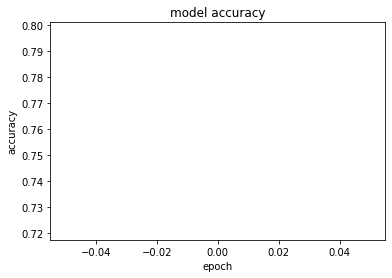

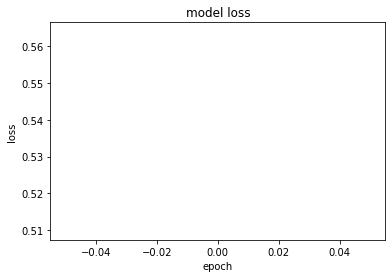

In [ ]:
history = model.fit(X_train, y_train, verbose=0)

fig, ax0 = plt.subplots()
fig, ax1 = plt.subplots()

# 모델의 정확도를 그립니다.
ax0.plot(history.history['accuracy']) 
ax0.set(title='model accuracy', xlabel='epoch', ylabel='accuracy')

# 모델의 오차를 그립니다.
ax1.plot(history.history['loss'])
ax1.set(title='model loss', xlabel='epoch', ylabel='loss')

In [ ]:
history.history

{'accuracy': [0.7592425346374512], 'loss': [0.5369319915771484]}

## Decision Tree

### 하이퍼 파라미터

- min_samples_split
  - 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어에 사용.
  - default는 2이다. 작게 설정할수록 분할되는 노드가 많아져 과적합 가능성 증가.
- min_samples_leaf
  - 말단 노드가 되기위한 최소한의 샘플 수
  - 과적합 제어 용도. 비대칭적 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있어 이 경우에는 작게 설정.
- max_features
  - 최적의 분할을 위해 고려할 최대 feature 개수. default는 None으로 데이터 세트의 모든 feature을 사용하여 분할.
  - int로 지정 시 대상 feature 개수, float로 지정 시 전체 feature중 대상 feature의 퍼센트
  - sqrt는 전체 feature중 제곱근 값.
  - auto는 sqrt와 동일
  - log는 전체 featur을 log2()로 선정
- max_depth
  - 트리의 최대 깊이 지정
  - default는 None. 이는 완벽히 클래스 결정값이 될때 까지 깊이를 계속 키우거나 노드가 가지는 데이터 개수가 min_samples_split보다 작아질 때 까지 계속 분할
  - 깊이가 깊어지면 min_samples_split 설정대로 최대 분할하여 과적합할 수 있으므로 적당한 값으로 제어.
- max_leaf_nodes
  - 말단 노드 최대 개수

- 출처: https://velog.io/@lsmmay322/%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%ACDecision-Tree

In [ ]:
# 사용자의 일반정보를 제외하고 만들어보기

# X = pd.concat([binary, categoryH0, categoryH1, ctn], axis=1)
# y = dataset['HYPERTENSION']  # 고혈압 변수

# # 훈련 데이터 나눔
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

ht_tree = DecisionTreeClassifier(max_depth=5)
# ht_tree = DecisionTreeClassifier()
ht_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
!ls

drive  sample_data  tree.dot


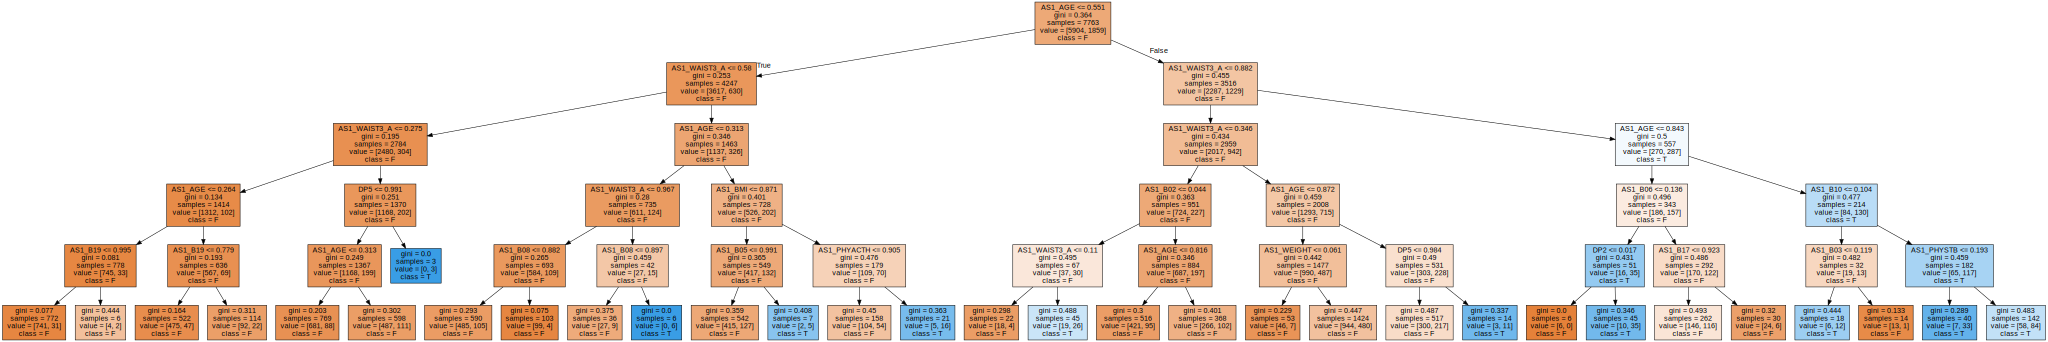

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

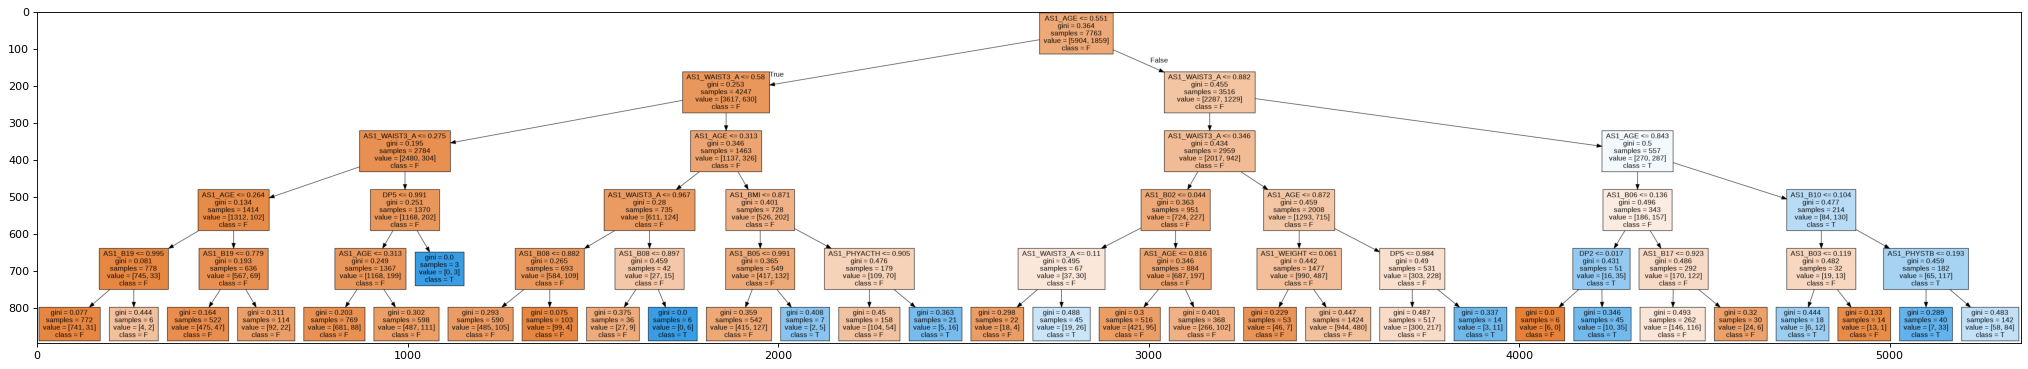

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

In [ ]:
print("훈련 세트 정확도: {:.3f}".format(ht_tree.score(X_train, y_train)))
print("테스트 세트 정확도: {:.3f}".format(ht_tree.score(X_test, y_test)))

훈련 세트 정확도: 0.776
테스트 세트 정확도: 0.778


Text(0, 0.5, 'feature importance')

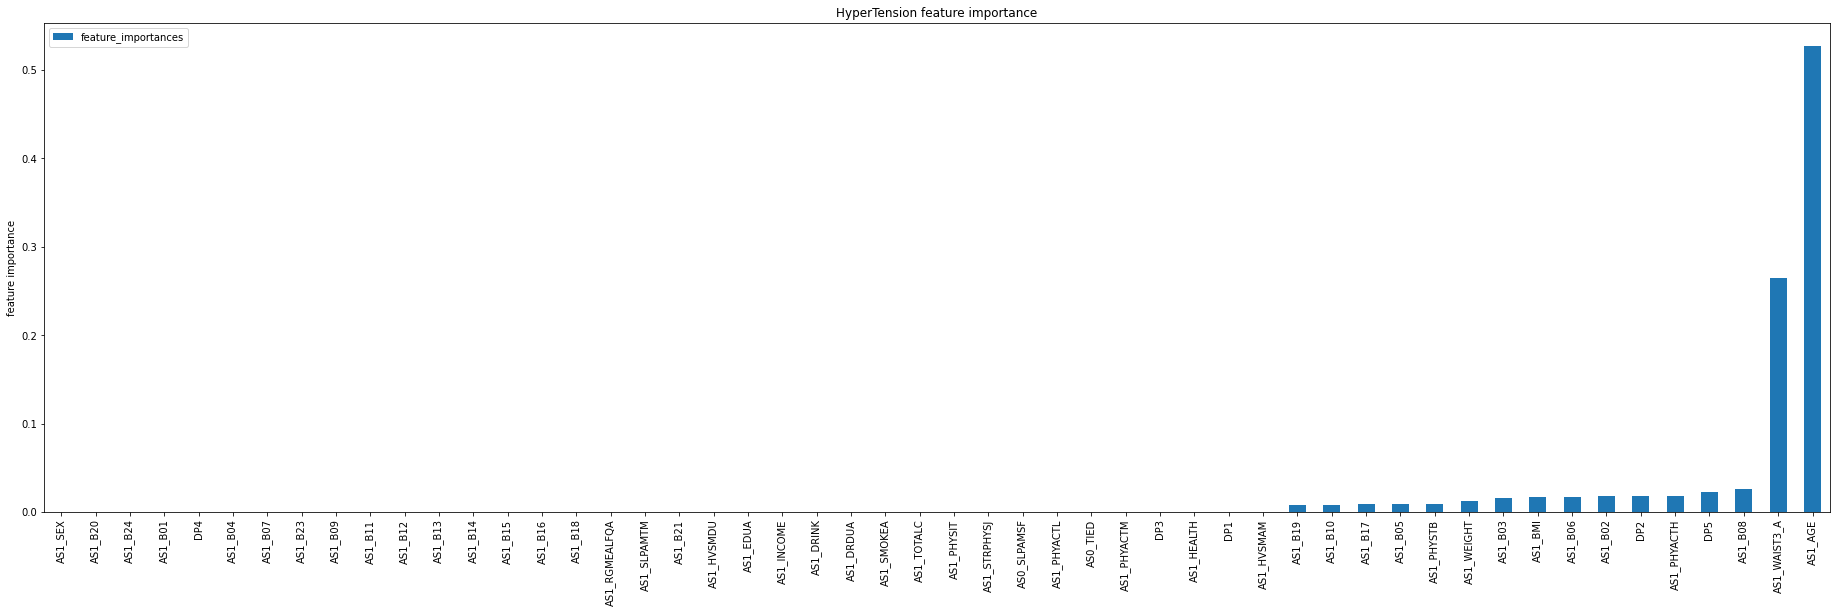

In [ ]:
importances = ht_tree.feature_importances_

tree_importances = pd.DataFrame({'feature_importances' : importances}, index=X.columns )
tree_importances.sort_values(by=['feature_importances'], axis=0, inplace=True)

# 특성 중요도 그래프
fig, ax = plt.subplots(figsize=(32, 9))
tree_importances.plot.bar(ax=ax)
ax.set_title("HyperTension feature importance")
ax.set_ylabel("feature importance")

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# ht_forest = RandomForestClassifier(n_estimators = 500, max_depth=5)
ht_forest = RandomForestClassifier(n_estimators = 500)

ht_forest.fit(X_train, y_train)

print("훈련 세트 정확도: {:.4f}".format(ht_forest.score(X_train, y_train)))
print("테스트 세트 정확도: {:.4f}".format(ht_forest.score(X_test, y_test)))

훈련 세트 정확도: 1.0000
테스트 세트 정확도: 0.7821


In [ ]:
est = ht_forest.estimators_

export_graphviz(est[5], out_file="forest.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
with open("forest.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='forest.png',format='png')

Output hidden; open in https://colab.research.google.com to view.

Text(0, 0.5, 'feature importance')

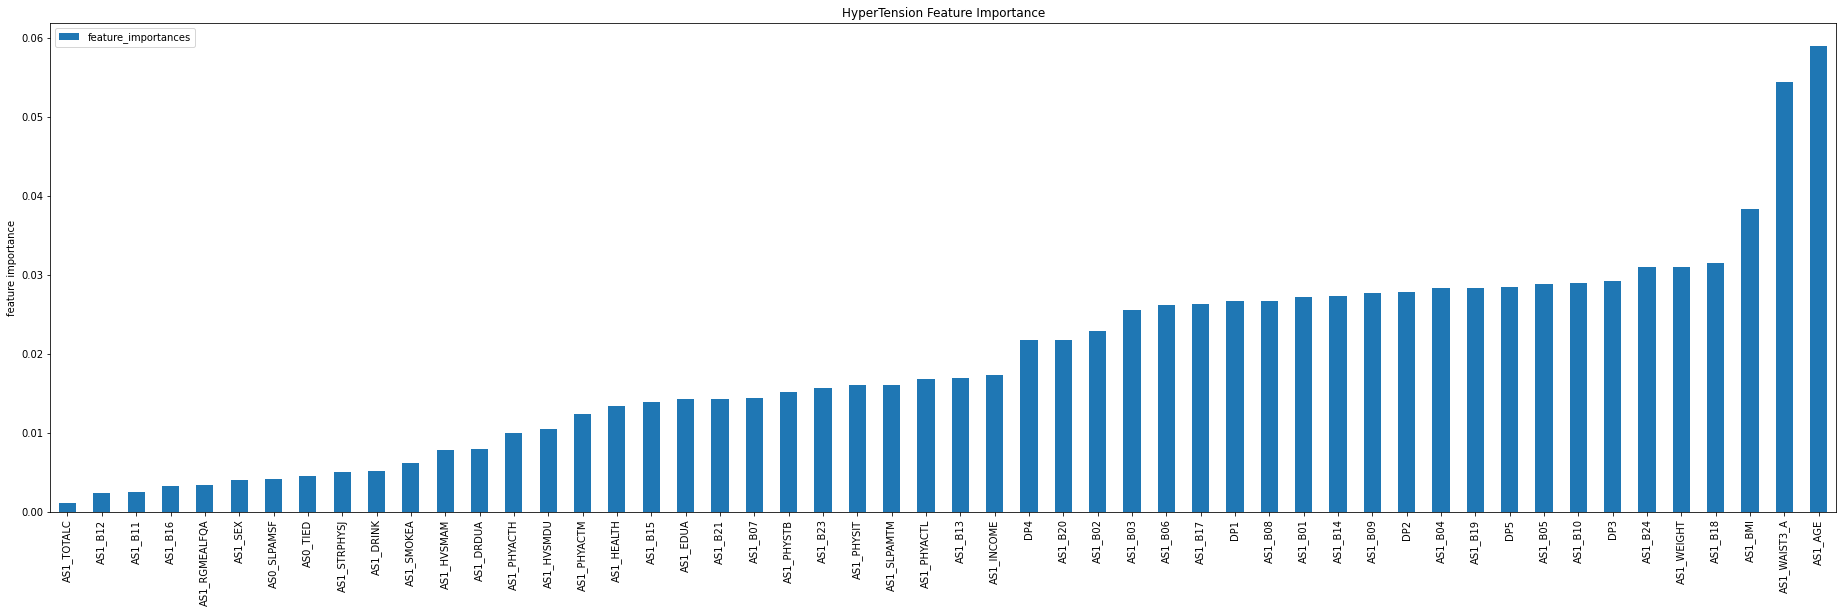

In [ ]:
f_importances = ht_forest.feature_importances_

forest_importances = pd.DataFrame({'feature_importances' : f_importances}, index=X.columns )
forest_importances.sort_values(by=['feature_importances'], axis=0, inplace=True)

# 특성 중요도 그래프
fig, ax = plt.subplots(figsize=(32, 9))
forest_importances.plot.bar(ax=ax)
ax.set_title("HyperTension Feature Importance")
ax.set_ylabel("feature importance")

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
forest_param_grid = {
    'n_estimators' : range(100, 10001, 100),
    'max_depth' : range(3, 10), 
} # 3 ~ 9

rf_grid = GridSearchCV(ht_forest, param_grid = forest_param_grid, scoring = 'accuracy')
rf_grid.fit(X_train, y_train)

print("최고 평균 정확도: {:.3f}".format(rf_grid.best_score_))
print("최고의 파라미터", rf_grid.best_params_)

In [ ]:
print("최고 평균 정확도: {:.3f}".format(rf_grid.best_score_))
print("최고의 파라미터", rf_grid.best_params_)

## 특성 중요도가 낮은 것 제외하고 모델 제작해보기

- Decision tree로 변수의 특성 중요도 추출,

In [ ]:
tree_importances_0 = tree_importances[tree_importances.feature_importances > 0]
tree_importances_0.info()

In [ ]:
importances_rank = tree_importances.index.to_numpy()

X_cut10 = X[importances_rank[10:]] # 변수 중요도 하위 10개 제거
X_cut20 = X[importances_rank[20:]] # 변수 중요도 하위 20개 제거
X_cut30 = X[importances_rank[30:]]
X_cut40 = X[importances_rank[40:]]
X_cut50 = X[importances_rank[50:]]

X_cut = X[tree_importances_0.index]

In [ ]:
X_cut_train, X_cut_test, y_train, y_test = train_test_split(X_cut, y, test_size=0.2)
print(X_cut_train.shape, X_cut_test.shape, y_train.shape, y_test.shape)

In [ ]:
cutted_tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = EPOCH,
                     hyperband_iterations = EPOCH,
                     directory = '/content/drive/MyDrive/Colab Notebooks',
                     project_name = 'HyperTension_sh22h_cutted_0913_03')

cutted_tuner.search(X_cut_train, y_train,
                    epochs = EPOCH,
                    validation_split=0.2,
                    callbacks = [ClearTrainingOutput()])

In [ ]:
# Get the optimal hyperparameters
cutted_hps = cutted_tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
{cutted_hps.get('units')}
최적의 학습률은
{cutted_hps.get('learning_rate')}
최적의 드롭아웃 확률은
{cutted_hps.get('dropout')}.
""")

### 하위 50개 제거 모델

```
Trial 365 Complete [00h 00m 03s]
val_accuracy: 0.769478440284729

Best val_accuracy So Far: 0.7746297717094421
Total elapsed time: 01h 02m 19s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
48
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

### 상위 18 모델

```
Trial 374 Complete [00h 00m 06s]
val_accuracy: 0.7720540761947632

Best val_accuracy So Far: 0.7759175896644592
Total elapsed time: 01h 08m 56s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in the densely-connected layer is
60
and the optimal learning rate for the optimizer is
0.001
drop-out is
0.05.
```

### 상위 17 (허리둘레 추가) 모델
```
Trial 809 Complete [00h 00m 03s]
val_accuracy: 0.7733418941497803

Best val_accuracy So Far: 0.7765614986419678
Total elapsed time: 01h 54m 06s
INFO:tensorflow:Oracle triggered exit

//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
104
최적의 학습률은
0.001
최적의 드롭아웃 확률은
0.35000000000000003.
``` 

In [ ]:
model = cutted_tuner.hypermodel.build(cutted_hps)
scores = model.evaluate(X_cut_test, y_test)
print("%s: %.2f, %s: %.2f%%" % (model.metrics_names[0], scores[0], model.metrics_names[1], scores[1] * 100))

In [ ]:
model.summary()

## 테스트 데이터 분석

### describe()

In [ ]:
X_train.describe()

In [ ]:
X_test.describe()

### value_counts()

In [ ]:
bins = list(range(40, 71, 10))
bins_label = [str(x)+"대" for x in bins]

count_X_train_AS1_AGE = pd.cut(X_train['AS1_AGE'], bins, right=False, labels=bins_label[:-1])
print(count_X_train_AS1_AGE.value_counts())

count_X_test_AS1_AGE = pd.cut(X_test['AS1_AGE'], bins, right=False, labels=bins_label[:-1])
print(count_X_test_AS1_AGE.value_counts())

In [ ]:
X_train['AS1_SEX'].value_counts()

In [ ]:
X_test['AS1_SEX'].value_counts()

In [ ]:
print(pd.Series(X_train['AS1_JOBB_0.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_1.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_2.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_3.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_4.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_5.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_6.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_7.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_JOBB_8.0'] == 0).value_counts())

In [ ]:
print(pd.Series(X_test['AS1_JOBB_0.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_1.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_2.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_3.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_4.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_5.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_6.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_7.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_JOBB_8.0'] == 0).value_counts())

In [ ]:
print(X_train['AS1_EDUA'].value_counts())
print(X_test['AS1_EDUA'].value_counts())

In [ ]:
print(X_train['AS1_INCOME'].value_counts())
print(X_test['AS1_INCOME'].value_counts())

In [ ]:
print(X_train['AS1_DRINK'].value_counts())
print(X_test['AS1_DRINK'].value_counts())

In [ ]:
print(X_train['AS1_DRDUA'].value_counts())
print(X_test['AS1_DRDUA'].value_counts())

In [ ]:
print(X_train['AS1_SMOKEA'].value_counts())
print(X_test['AS1_SMOKEA'].value_counts())

In [ ]:
print(X_train['AS1_PHYSTB'].value_counts())
print(X_test['AS1_PHYSTB'].value_counts())

In [ ]:
print(X_train['AS1_PHYSIT'].value_counts().sort_index())
print(X_test['AS1_PHYSIT'].value_counts().sort_index()) 

In [ ]:
print(X_train['AS1_PHYACTL'].value_counts().sort_index())
print(X_test['AS1_PHYACTL'].value_counts().sort_index())

In [ ]:
print(X_train['AS1_PHYACTM'].value_counts().sort_index())
print(X_test['AS1_PHYACTM'].value_counts().sort_index())

In [ ]:
print(X_train['AS1_PHYACTH'].value_counts().sort_index())
print(X_test['AS1_PHYACTH'].value_counts().sort_index())

In [ ]:
print(pd.Series(X_train['AS1_INSUR_1.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_INSUR_2.0'] == 0).value_counts())
print(pd.Series(X_train['AS1_INSUR_3.0'] == 0).value_counts())

In [ ]:
print(pd.Series(X_test['AS1_INSUR_1.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_INSUR_2.0'] == 0).value_counts())
print(pd.Series(X_test['AS1_INSUR_3.0'] == 0).value_counts())

In [ ]:
print(X_train['AS1_HEALTH'].value_counts().sort_index())
print(X_test['AS1_HEALTH'].value_counts().sort_index())

In [ ]:
print(X_train['AS0_TIED'].value_counts().sort_index())
print(X_test['AS0_TIED'].value_counts().sort_index())

In [ ]:
print(X_train['AS0_SLPAMSF'].value_counts().sort_index())
print(X_test['AS0_SLPAMSF'].value_counts().sort_index())

In [ ]:
print(X_train['AS1_STRPHYSJ'].value_counts().sort_index())
print(X_test['AS1_STRPHYSJ'].value_counts().sort_index())

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
f1_f17 = np.array(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9',
                   'F10', 'F11', 'F12', 'F13', 'F14','F15', 'F16', 'F17'])

f_train_mean = X_train[f1_f17].mean().to_numpy()
f_test_mean = X_test[f1_f17].mean().to_numpy()
f_train_min = X_train[f1_f17].min().to_numpy()
f_test_min = X_test[f1_f17].min().to_numpy()
f_train_max = X_train[f1_f17].max().to_numpy()
f_test_max = X_test[f1_f17].max().to_numpy()

print("X_train")
for x in range(17):
  print(f"""{round(f_train_mean[x], 6)}\n({int(f_train_min[x])} - {int(f_train_max[x])})""")
  print()
print("X_test")
for x in range(17):
  print(f"""{round(f_test_mean[x], 6)}\n({int(f_test_min[x])} - {int(f_test_max[x])})""")
  print()
